https://www.kaggle.com/code/brsdincer/mri-hippocampus-alzheimer-segmentation-all-process/notebook#DATA-PROCESS

image, label concat해서 학습해보기

### MAE를 metric으로 평가

#### kaggle에서 load

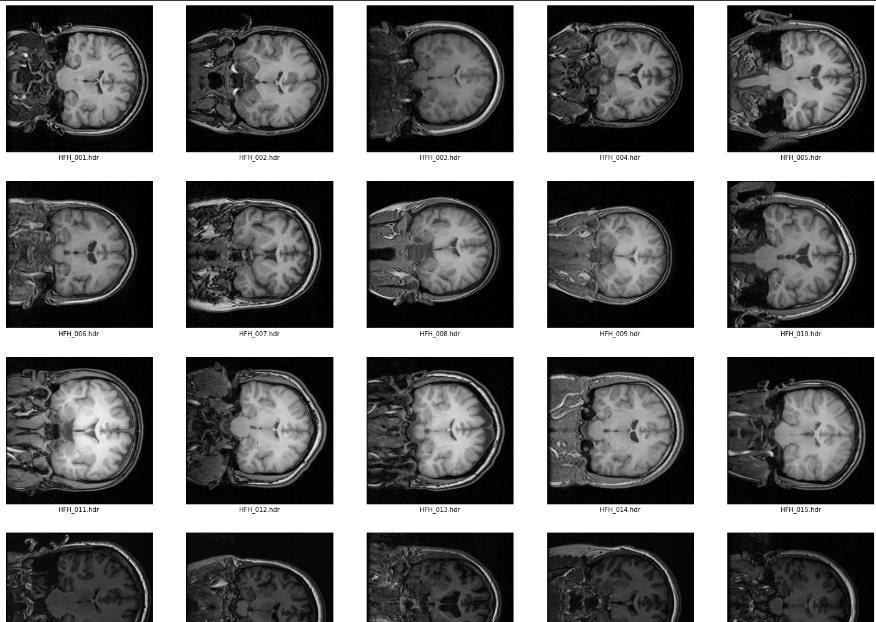

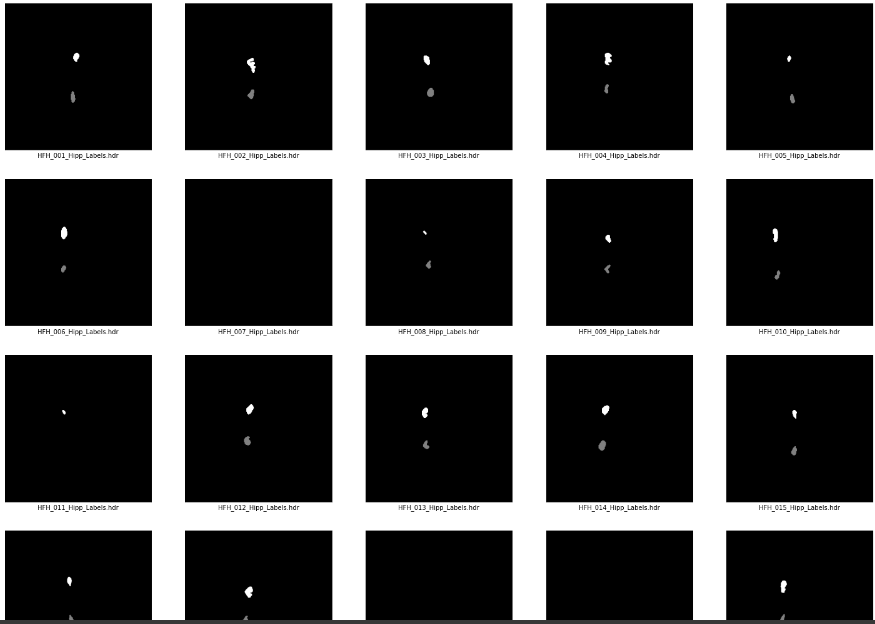

In [1]:
from google.colab import files
upload = files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
!kaggle datasets download -d andrewmvd/hippocampus-segmentation-in-mri-images
!unzip -qq /content/hippocampus-segmentation-in-mri-images.zip

Saving kaggle.json to kaggle.json
 98% 793M/806M [00:04<00:00, 235MB/s]
100% 806M/806M [00:04<00:00, 172MB/s]


In [1]:
from skimage.transform import resize
import os, glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
def load_data(path, size=(128, 128), arr=True):
  # from skimage.transform import resize
  # import os, glob
  # import numpy as np
  # import nibabel as nib

  root = glob.glob(os.path.join(path, '*.hdr'))
  root.sort()

  ls = list()
  for idx, f in enumerate(root):
    hdr = nib.load(f).get_fdata()
    # print(idx+1)
    for i in hdr:
      h = resize(i, size)
      # h = h / h.max()
      # h = h * 256.
      ls.append(h.reshape(h.shape[0], h.shape[1]))
  
  if arr == True:
    data = np.asarray(ls)
    print('Done array!')
    return data
  
  else:
    print('Done image!')
    return ls
  

In [3]:
X = load_data('/content/Train')
y = load_data('/content/Train/Labels')
X_test = load_data('/content/Test', arr=False)

Done array!
Done array!
Done image!


### Visualization

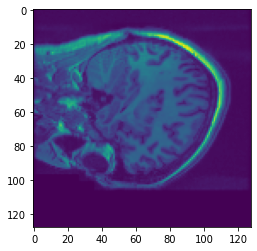

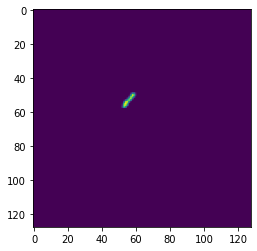

In [ ]:
idx= 5700

plt.imshow(hdr_X[idx].reshape(hdr_X[idx].shape[0], hdr_X[idx].shape[1]))
plt.show()
plt.imshow(hdr_y[idx].reshape(hdr_X[idx].shape[0], hdr_X[idx].shape[1]))
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
print('X_train :', X_train.shape)
print('X_val   :', X_val.shape)
print('y_train :', y_train.shape)
print('y_val   :', y_val.shape)
print('X_test  :', np.array(X_test).shape)

X_train : (7168, 128, 128)
X_val   : (1792, 128, 128)
y_train : (7168, 128, 128)
y_val   : (1792, 128, 128)
X_test  : (8960, 128, 128)


In [7]:
from tensorflow import keras
from keras import layers

img_size = X_train[0].shape
num_classes = 1

inputs = keras.Input(shape=img_size + (1,))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Conv2D(128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Conv2D(256, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(256, kernel_size=3, activation="relu", padding="same")(x)

x = layers.Conv2DTranspose(256, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(256, kernel_size=3, activation="relu", padding="same", strides=2)(x)
x = layers.Conv2DTranspose(128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(128, kernel_size=3, activation="relu", padding="same", strides=2)(x)
x = layers.Conv2DTranspose(64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, kernel_size=3, activation="relu", padding="same", strides=2)(x)

outputs = layers.Conv2D(num_classes, kernel_size=3, activation="sigmoid", padding="same")(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       295168

In [8]:
from keras.callbacks import *

callbacks = [EarlyStopping(patience=5,
                           monitor='val_loss'),
             ModelCheckpoint('hippo_seg.keras',
                             save_best_only=True)]

In [9]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=16,
                    validation_data=(X_val, y_val))

Epoch 1/50
448/448 [==============================] - 39s 62ms/step - loss: 0.0204 - acc: 0.9975 - mae: 0.0064 - val_loss: 0.0112 - val_acc: 0.9988 - val_mae: 7.2352e-04
Epoch 2/50
448/448 [==============================] - 28s 62ms/step - loss: 0.0129 - acc: 0.9988 - mae: 8.3750e-04 - val_loss: 0.0112 - val_acc: 0.9988 - val_mae: 7.2352e-04
Epoch 3/50
448/448 [==============================] - 28s 62ms/step - loss: 0.0129 - acc: 0.9988 - mae: 8.3750e-04 - val_loss: 0.0112 - val_acc: 0.9988 - val_mae: 7.2352e-04
Epoch 4/50
448/448 [==============================] - 28s 64ms/step - loss: 0.0129 - acc: 0.9988 - mae: 8.3750e-04 - val_loss: 0.0112 - val_acc: 0.9988 - val_mae: 7.2352e-04
Epoch 5/50
448/448 [==============================] - 29s 65ms/step - loss: 0.0129 - acc: 0.9988 - mae: 8.3750e-04 - val_loss: 0.0112 - val_acc: 0.9988 - val_mae: 7.2352e-04
Epoch 6/50
448/448 [==============================] - 30s 66ms/step - loss: 0.0129 - acc: 0.9988 - mae: 8.3750e-04 - val_loss: 0.0112 

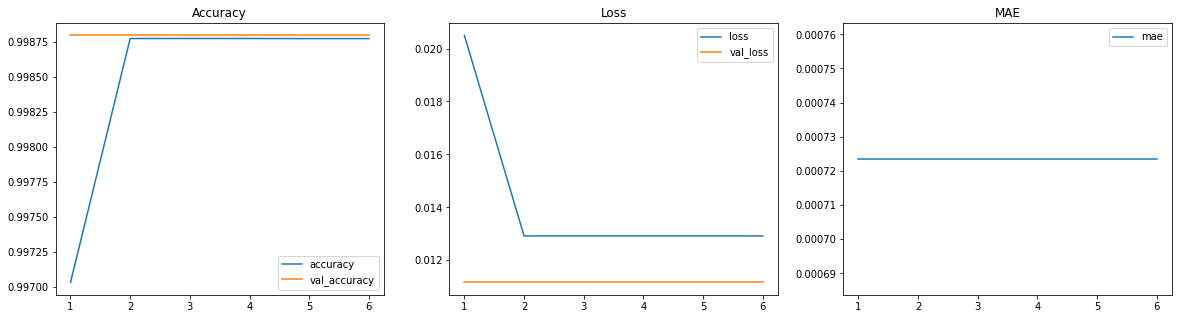

Validation loss : 0.011160241439938545
Validation accuracy : 0.9987981915473938


In [10]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
mae = history.history['val_mae']
epoch = np.arange(1, len(acc)+1)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(epoch, acc, label='accuracy')
plt.plot(epoch, val_acc, label='val_accuracy')

plt.legend()
plt.title('Accuracy')

plt.subplot(132)
plt.plot(epoch, loss, label='loss')
plt.plot(epoch, val_loss, label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(133)
plt.plot(epoch, mae, label='mae')
plt.legend()
plt.title('MAE')

plt.show()
print('Validation loss :', val_loss[-1])
print('Validation accuracy :', val_acc[-1])

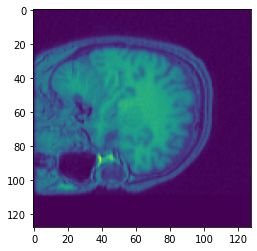

In [33]:
idx = 600

plt.imshow(X_test[idx].reshape(X_test[idx].shape[0], X_test[idx].shape[1]))
plt.show()

1/1 [==============================] - 0s 183ms/step
(1, 128, 128, 1)


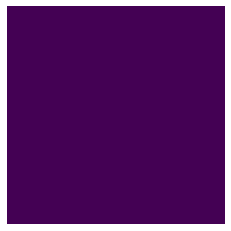

In [34]:
from keras.utils import array_to_img

model = keras.models.load_model('/content/hippo_seg.keras')

i = 600
test_image = X_test[i].reshape(X_test[i].shape[0], X_test[i].shape[1], 1)
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))
print(mask.shape)
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask[0])

display_mask(mask)